
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder

# Loading data
Data consists of all PL players logs for 2021-22 and 2022-23 seasons\
A single log is just a summary of player performance in a particular match

In [3]:
# loading csv
df_original = pd.read_csv('data/FPL_logs.csv')

df = df_original.copy()

In [4]:
df_original.columns

Index(['Date', 'Day', 'Venue', 'Team', 'Opponent', 'Name', 'Start', 'Pos',
       'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xA', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'T_att', 'T_succ',
       'Season', 'WDL', 'Team_score', 'Opp_score', 'Team_CS', 'Was_home', 'GW',
       'Clean_name', 'FPL_name', 'FPL_team', 'FPL_opp_team', 'Name_original',
       'FPL_pos', 'FPL_ast', 'Bonus', 'Bps', 'Player_CS', 'Creativity',
       'Element', 'Fixture', 'Player_GC', 'Goals_scored', 'ICT_index',
       'Influence', 'Kickoff_time', 'FPL_min', 'Own_goals', 'Penalties_missed',
       'Penalties_saved', 'Saves', 'Selected', 'Threat', 'FPL_points',
       'Transfers_balance', 'Transfers_in', 'Transfers_out', 'Value', 'FPL_GW',
       'xP', 'FPL_xA', 'FPL_xGI', 'FPL_xG', 'FPL_xGC', 'Opp_rating',
       'Team_rating', 'Min_points'],
      dtype='object')

In [5]:
df_original["Name"].unique().size

554

In [6]:
df.shape

(24573, 80)

In [7]:
df = df[~df["FPL_pos"].isin(["GK"])]

# Feature selection
Model will use a set of standard features and moving averages for some other feature values. In this case we will use moving averages for last 2, 4 and 30 gameweeks.

In [8]:
rolling_gameweeks = [2, 4, 30]
# rolling_gameweeks = [5]

to_predict = ["FPL_points"]
standard_features = [
             "Was_home", # Home/Away
             "Team_rating", "Opp_rating", "Rating_difference" # Team ratings
             ]
features_to_roll = [
                "Min", "Start", # time played
                'Gls', 'Sh', 'SoT', # Goals
                'Ast', # Assists
                'CrdY', 'CrdR', # Cards
                "xG", 'xA', # Expected
                'Team_CS', # Defence
                'Team_score', 'Opp_score', 'Team_result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "T_succ",
                # 'bonus', 'bps', # Bonus
                # 'Influence', 'Creativity', 'Threat', 
                'ICT_index', # ICT
                "FPL_points", "Baseline_points", "Bonus" # FPL points
            ]
info = ["Name_original", "GW", "Season", "Team", "Opponent", "Was_home", "Team_rating", "Opp_rating", "FPL_pos"]

# Feature engineering

In [9]:
df["Rating_difference"] = df["Team_rating"] / df["Opp_rating"]
df["Baseline_points"] = df["FPL_points"] - df["Bonus"]

In [10]:
def calculate_team_points(row):
    # win - 3 points
    if row['Team_score'] > row['Opp_score']:
        return 3
    # draw - 1 point
    elif row['Team_score'] == row['Opp_score']:
        return 1
    # loss - 0 points
    else:
        return 0
    
df['Team_result'] = df.apply(calculate_team_points, axis=1)

In [11]:
def add_rolling_features(df, standard_features, features_to_roll):
    features = standard_features
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        # print(form_means[form_means["Name"] == "Erling-Haaland"])
        form_means = form_means.fillna(method='bfill') # slightly incorrect, better to drop Nan
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df.reset_index(), form_means], axis=1)
        df = df.drop([col for col in df.columns if col.startswith('level')], axis=1)
        
    return df.reset_index(), features

In [12]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [13]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 1, # Starting eleven
        'Y*': 1, # Starting eleven as captain
        'N': 0, # Not in starting eleven
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [14]:
df = label_encoding(df, "Start")

In [15]:
df, features = add_rolling_features(df, standard_features, features_to_roll)

In [16]:
df, features = ohe(df, ["FPL_pos"], features)

In [17]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + to_predict)]

In [18]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [19]:
# dropping NaNs
df = df.dropna(axis=0)

In [20]:
df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [21]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'Baseline_points_2', 'Baseline_points_30',
       'Baseline_points_4', 'Bonus_2', 'Bonus_30', 'Bonus_4', 'CrdR_2',
       'CrdR_30', 'CrdR_4', 'CrdY_2', 'CrdY_30', 'CrdY_4', 'DEF', 'FPL_points',
       'FPL_points_2', 'FPL_points_30', 'FPL_points_4', 'FPL_pos', 'FWD', 'GW',
       'Gls_2', 'Gls_30', 'Gls_4', 'ICT_index_2', 'ICT_index_30',
       'ICT_index_4', 'MID', 'Min_2', 'Min_30', 'Min_4', 'Name_original',
       'Opp_rating', 'Opp_score_2', 'Opp_score_30', 'Opp_score_4', 'Opponent',
       'Rating_difference', 'Season', 'Sh_2', 'Sh_30', 'Sh_4', 'SoT_2',
       'SoT_30', 'SoT_4', 'Start_2', 'Start_30', 'Start_4', 'Team',
       'Team_CS_2', 'Team_CS_30', 'Team_CS_4', 'Team_rating', 'Team_result_2',
       'Team_result_30', 'Team_result_4', 'Team_score_2', 'Team_score_30',
       'Team_score_4', 'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30',
       'xG_4'],
      dtype='object')

In [22]:
df.shape

(20111, 68)

In [23]:
# saving to file
df.to_csv("data/df_features.csv", index=False)

# Data split into train and valid
Let's take entire 2021-22 season and 30 first gameweeks of 2022-23 season as training data and 8 last gameweeks of that season as valid data (~10% of all rows).

In [24]:
CUT_OFF_GAMEWEEK = 31
SEASON_TO_PREDICT = "2022-23"

In [25]:
# training data
X_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= CUT_OFF_GAMEWEEK - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= CUT_OFF_GAMEWEEK - 1))][to_predict].reset_index(drop=True)

In [26]:
# no goalkeepers
df = df[~df["FPL_pos"].isin(["GK"])]

In [27]:
# only 31st gameweek
X_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [28]:
# all remaining gameweeks
X_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [29]:
X_train.shape, X_test.shape, X_test_all_remaining.shape

((17426, 61), (333, 61), (2685, 61))

# Model

In [30]:
model = GradientBoostingRegressor(random_state=42)
# model = XGBRegressor(random_state=42)
# model = RandomForestRegressor(random_state=42)

In [31]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 8.44 s
Wall time: 8.69 s


GradientBoostingRegressor(random_state=42)

# Getting predictions

In [32]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data and glues them to the rest of the dataframe
    predictions = model.predict(X)
    
    if all_remaining:
        df_predictions = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "Pred"] = predictions
    
    preds = df_predictions[info + to_predict + ["Pred"]].sort_values(by=["Pred"], ascending = False)
    
    return preds, predictions

In [33]:
preds, predictions = get_predictions(model, df, X_test)

In [34]:
preds_all_gameweeks, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

In [35]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'Baseline_points_2', 'Baseline_points_30',
       'Baseline_points_4', 'Bonus_2', 'Bonus_30', 'Bonus_4', 'CrdR_2',
       'CrdR_30', 'CrdR_4', 'CrdY_2', 'CrdY_30', 'CrdY_4', 'DEF', 'FPL_points',
       'FPL_points_2', 'FPL_points_30', 'FPL_points_4', 'FPL_pos', 'FWD', 'GW',
       'Gls_2', 'Gls_30', 'Gls_4', 'ICT_index_2', 'ICT_index_30',
       'ICT_index_4', 'MID', 'Min_2', 'Min_30', 'Min_4', 'Name_original',
       'Opp_rating', 'Opp_score_2', 'Opp_score_30', 'Opp_score_4', 'Opponent',
       'Rating_difference', 'Season', 'Sh_2', 'Sh_30', 'Sh_4', 'SoT_2',
       'SoT_30', 'SoT_4', 'Start_2', 'Start_30', 'Start_4', 'Team',
       'Team_CS_2', 'Team_CS_30', 'Team_CS_4', 'Team_rating', 'Team_result_2',
       'Team_result_30', 'Team_result_4', 'Team_score_2', 'Team_score_30',
       'Team_score_4', 'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30',
       'xG_4'],
      dtype='object')

# Custom metric
Such models are usually used to compare players and decide who to pick for upcoming gameweek(s). For each player pair in a subset of players model can either predict the outcome well (e.g. player A scores more than player B and model predicts exactly that) or predict wrongly (e.g. player A scores more than player B but model predicts player B > player A). Pairwise_accuracy returns the percentage of corrected predicted pairs. Pairwise_accuracy_topX is a variation of this metric calculated only for X highest scoring players of last two seasons.

In [36]:
def get_top_performer_names(df, no_top, no_gws):
    # takes no_top players that recorded highest average FPL points in no_gws last gameweeks
    return df.reset_index(drop=True).groupby("Name_original")["FPL_points"].mean().groupby("Name_original").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [37]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [38]:
def pairwise_accuracy_topX(model, df, top_x, all_gw=False):
    # pairwise_accuracy for top_X players
    if all_gw:
        top_performers = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]
    else:
        top_performers = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]

    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

# Evaluation

In [39]:
def evaluate(model, df, predictions, y_true, all_gw=False):
    # function to calculate different metrics for a given model
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20, all_gw)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100, all_gw)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)
    print("Avg pred vs avg true:", np.mean(predictions).round(2), "vs", np.mean(y_true).round(2).item())

In [40]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [41]:
# next gameweek
evaluate(model, df, predictions, y_test, all_gw=False)

MAE: 1.8087365369223622
MSE: 7.918895543051643
Pairwise accuracy: 0.5602228734758855
Pairwise accuracy @TOP100: 0.5000022045758176
Pairwise accuracy @TOP20: 0.5044579533941236
Avg pred vs avg true: 2.16 vs 2.27


In [42]:
# all remaining gameweeks
evaluate(model, df, predictions_all, y_test_all_remaining, all_gw=True)

MAE: 1.7832617510189714
MSE: 7.231169897919073
Pairwise accuracy: 0.5626061882678789
Pairwise accuracy @TOP100: 0.4481792717086835
Pairwise accuracy @TOP20: 0.5730994152046783
Avg pred vs avg true: 2.21 vs 2.22


In [43]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [44]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [45]:
features

['Was_home',
 'Team_rating',
 'Opp_rating',
 'Rating_difference',
 'Min_2',
 'Start_2',
 'Gls_2',
 'Sh_2',
 'SoT_2',
 'Ast_2',
 'CrdY_2',
 'CrdR_2',
 'xG_2',
 'xA_2',
 'Team_CS_2',
 'Team_score_2',
 'Opp_score_2',
 'Team_result_2',
 'ICT_index_2',
 'FPL_points_2',
 'Baseline_points_2',
 'Bonus_2',
 'Min_4',
 'Start_4',
 'Gls_4',
 'Sh_4',
 'SoT_4',
 'Ast_4',
 'CrdY_4',
 'CrdR_4',
 'xG_4',
 'xA_4',
 'Team_CS_4',
 'Team_score_4',
 'Opp_score_4',
 'Team_result_4',
 'ICT_index_4',
 'FPL_points_4',
 'Baseline_points_4',
 'Bonus_4',
 'Min_30',
 'Start_30',
 'Gls_30',
 'Sh_30',
 'SoT_30',
 'Ast_30',
 'CrdY_30',
 'CrdR_30',
 'xG_30',
 'xA_30',
 'Team_CS_30',
 'Team_score_30',
 'Opp_score_30',
 'Team_result_30',
 'ICT_index_30',
 'FPL_points_30',
 'Baseline_points_30',
 'Bonus_30',
 'DEF',
 'FWD',
 'MID']

In [46]:
len(features)

61

# Predictions - next gameweek only

In [47]:
preds.head(30)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
114,Harry Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FWD,2.0,6.136949
195,Leandro Trossard,31,2022-23,Arsenal,West Ham,0.0,1957.524048,1754.553955,MID,1.0,5.647419
96,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,5.181071
237,Mohamed Salah,31,2022-23,Liverpool,Leeds United,0.0,1928.520996,1698.080566,MID,14.0,5.089439
299,Son Heung-min,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,MID,9.0,5.022564
128,Ivan Toney,31,2022-23,Brentford,Wolves,0.0,1785.234741,1720.871338,FWD,2.0,4.988477
217,Martin Ødegaard,31,2022-23,Arsenal,West Ham,0.0,1957.524048,1754.553955,MID,10.0,4.957936
218,Gabriel Martinelli Silva,31,2022-23,Arsenal,West Ham,0.0,1957.524048,1754.553955,MID,5.0,4.912686
184,Kevin De Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,8.0,4.859917
188,Kieran Trippier,31,2022-23,Newcastle Utd,Aston Villa,0.0,1879.303101,1804.471680,DEF,1.0,4.791103


In [48]:
preds[preds["Team"] == "Manchester City"].head(20)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
96,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,5.181071
184,Kevin De Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,8.0,4.859917
129,Jack Grealish,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,7.0,4.546967
176,Julián Álvarez,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,1.0,3.886505
124,Ilkay Gündogan,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,0.0,3.843058
284,Rúben Gato Alves Dias,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,2.0,3.569329
244,Nathan Aké,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,0.0,3.542312
209,Manuel Akanji,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,1.0,3.472601
31,Bernardo Veiga de Carvalho e Silva,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,1.0,3.373327
169,John Stones,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,8.0,3.357930


# Predictions - all remaining gameweeks

In [49]:
preds_all_gameweeks.head(15)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
785,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,FWD,2.0,8.838909
1903,Mohamed Salah,37,2022-23,Liverpool,Aston Villa,1.0,1958.159424,1815.086426,MID,5.0,6.956389
1465,Kevin De Bruyne,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,MID,3.0,6.569145
787,Erling Haaland,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,FWD,1.0,6.337705
345,Callum Wilson,37,2022-23,Newcastle Utd,Leicester City,1.0,1882.392212,1710.457275,FWD,2.0,6.244086
922,Harry Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FWD,2.0,6.136949
1900,Mohamed Salah,34,2022-23,Liverpool,Tottenham,1.0,1936.814331,1820.079712,MID,7.0,6.069277
1898,Mohamed Salah,32,2022-23,Liverpool,Nott'ham Forest,1.0,1930.005737,1626.679321,MID,7.0,6.039193
1901,Mohamed Salah,35,2022-23,Liverpool,Brentford,1.0,1943.223999,1784.843750,MID,10.0,6.028171
2041,Ollie Watkins,33,2022-23,Aston Villa,Fulham,1.0,1812.839722,1725.331177,FWD,2.0,5.918922


In [50]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Mohamed Salah"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
1897,Mohamed Salah,31,2022-23,Liverpool,Leeds United,0.0,1928.520996,1698.080566,MID,14.0,5.089439
1898,Mohamed Salah,32,2022-23,Liverpool,Nott'ham Forest,1.0,1930.005737,1626.679321,MID,7.0,6.039193
1899,Mohamed Salah,33,2022-23,Liverpool,West Ham,0.0,1931.599731,1774.066772,MID,2.0,4.462454
1900,Mohamed Salah,34,2022-23,Liverpool,Tottenham,1.0,1936.814331,1820.079712,MID,7.0,6.069277
1901,Mohamed Salah,35,2022-23,Liverpool,Brentford,1.0,1943.223999,1784.843750,MID,10.0,6.028171
1902,Mohamed Salah,36,2022-23,Liverpool,Leicester City,0.0,1947.327637,1712.013672,MID,12.0,5.366900
1903,Mohamed Salah,37,2022-23,Liverpool,Aston Villa,1.0,1958.159424,1815.086426,MID,5.0,6.956389
1904,Mohamed Salah,38,2022-23,Liverpool,Southampton,0.0,1953.153564,1619.777344,MID,5.0,5.778256


In [51]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Erling Haaland"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
782,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,5.181071
788,Erling Haaland,32,2022-23,Manchester City,Brighton,0.0,2091.929932,1829.306519,FWD,5.0,5.362558
783,Erling Haaland,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FWD,14.0,4.616261
784,Erling Haaland,34,2022-23,Manchester City,Fulham,0.0,2067.576904,1720.540771,FWD,8.0,4.769614
785,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,FWD,2.0,8.838909
786,Erling Haaland,36,2022-23,Manchester City,Everton,0.0,2074.110596,1697.794434,FWD,7.0,5.426925
787,Erling Haaland,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,FWD,1.0,6.337705
789,Erling Haaland,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,FWD,0.0,5.761563


In [52]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Harry Kane"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
922,Harry Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FWD,2.0,6.136949
923,Harry Kane,32,2022-23,Tottenham,Newcastle Utd,0.0,1834.483765,1857.315674,FWD,6.0,4.814888
924,Harry Kane,33,2022-23,Tottenham,Manchester Utd,1.0,1820.470093,1854.124756,FWD,11.0,5.742595
925,Harry Kane,34,2022-23,Tottenham,Liverpool,0.0,1820.079712,1936.814331,FWD,8.0,4.400074
926,Harry Kane,35,2022-23,Tottenham,Crystal Palace,1.0,1816.056030,1752.288574,FWD,8.0,5.616347
927,Harry Kane,36,2022-23,Tottenham,Aston Villa,0.0,1822.077881,1803.241211,FWD,7.0,4.813419
928,Harry Kane,37,2022-23,Tottenham,Brentford,1.0,1819.507935,1796.138916,FWD,7.0,5.405376
929,Harry Kane,38,2022-23,Tottenham,Leeds United,0.0,1805.765259,1667.934448,FWD,16.0,5.188646


# Saving to file

In [53]:
preds_all_gameweeks.to_csv("predictions/all_predictions.csv", index=False)

In [54]:
pickle.dump(model, open("models/GBR.pkl", 'wb'))

# Feature importance and influence

In [55]:
explainer = shap.Explainer(model.predict, X_test_all_remaining)
shap_values = explainer(X_test_all_remaining)

Permutation explainer: 2686it [03:35, 12.12it/s]                                                                                                        


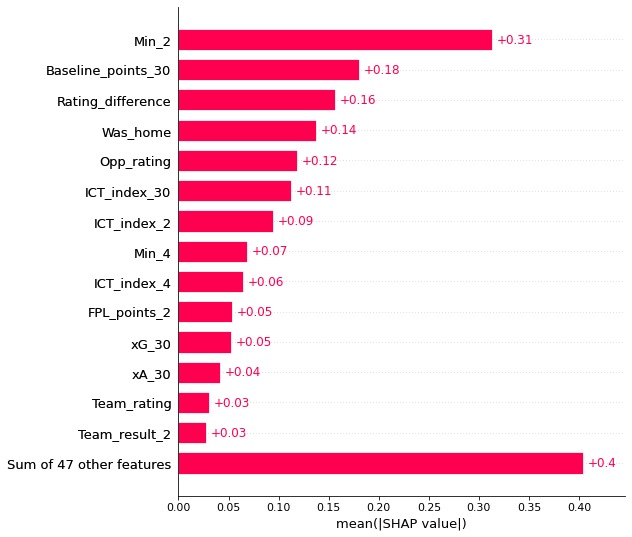

In [56]:
shap.plots.bar(shap_values, max_display=15)

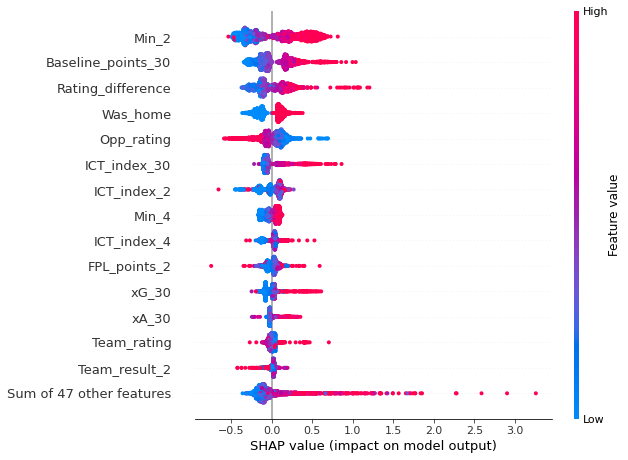

In [57]:
shap.plots.beeswarm(shap_values, max_display=15)

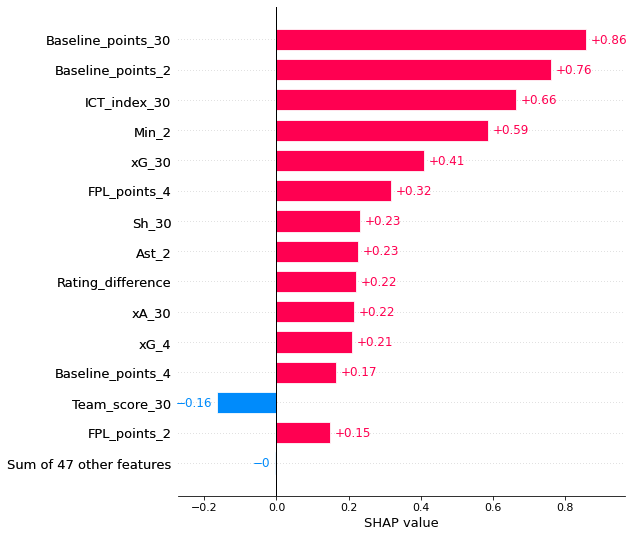

In [58]:
# explaining Erling Haaland`s score in gameweek 30
shap.plots.bar(shap_values[1903], max_display=15)